1. Check that training vanilla RNNs on the CDM task is successfull using CtD
2. Generate neural trajectories (synthetic data) with the data-trained model
3. Fit another RNN and verify the relationships between the original and the fitted connectivity matrix J as is Fig 1b in Valente et al.


Immediate next steps:

1. training on task

RNN (like 100 D) - cannot go to a 2D flow field
nODE (like 2 D) - can go to a flow field

LINT rnn model is a specialized version of the nODE


see how changing the rank of the initial rnn changes the flow field of the second fitted network. 

- the other validation first step is to use 2BFF and 3BFF and see if the FPs are recovered 

### Some questions

What exactly is fixation? 

Trouble matching working memory (WM) and decision making (DM)

go to multitask.py and try to match the parameters - the time marks in ctd are uniformly sampled as in Driscoll's paper, but prob we want to keep it to one?

where is J explicit at all in the VanillaRNN module? - should I really be using the vanilla RNN or the DriscollRNN?

Is the data simulator with the permutations of the latents from the model actually the neural trajectories we want?

In [14]:
import random
import dotenv
import pathlib
import os
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

# import sys
# # to find the modules in ctd
# sys.path.append(HOME_DIR)

/Users/alejandraduran/Documents/Brody_lab/gnode/


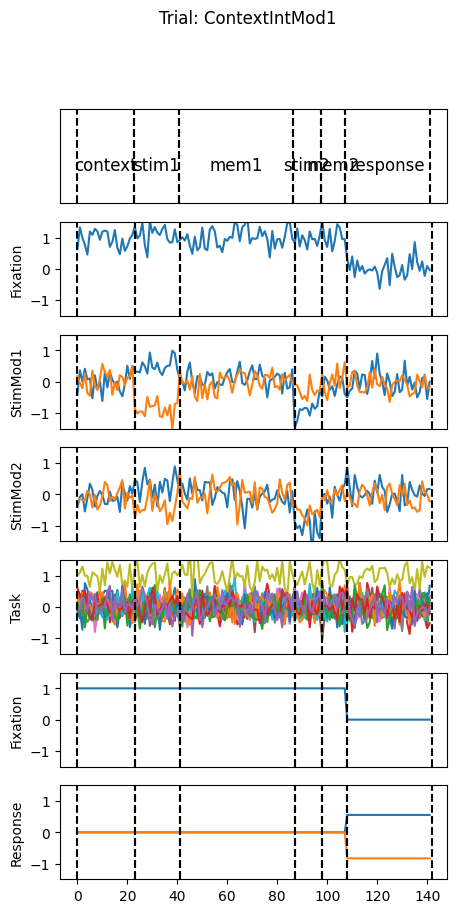

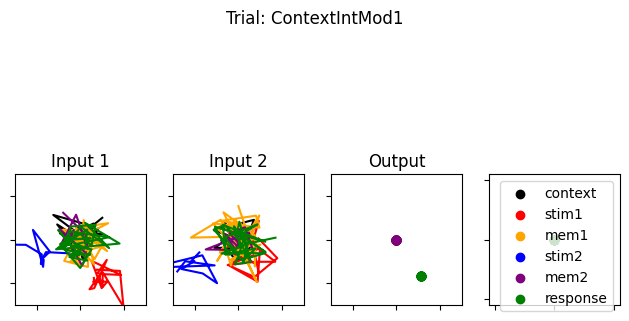

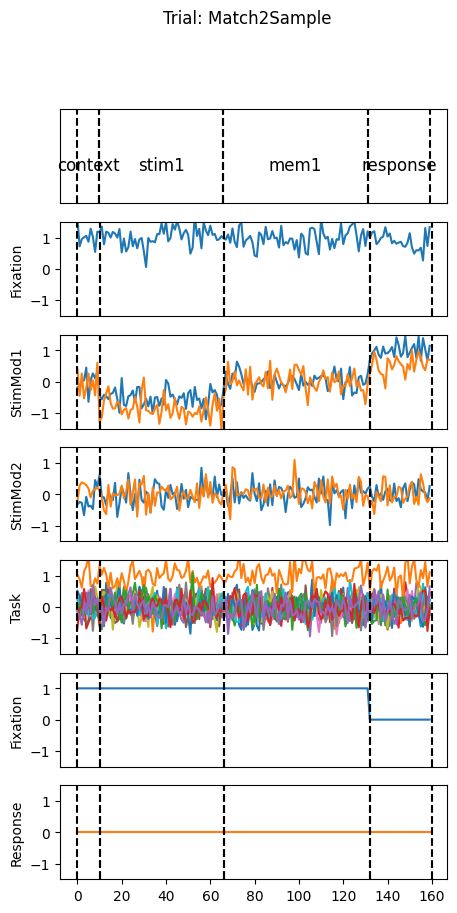

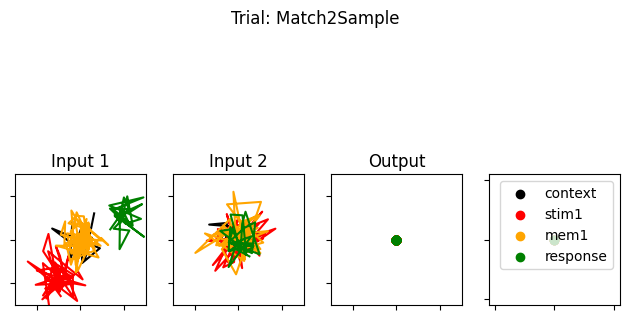

In [25]:
from ctd.task_modeling.task_env.multitask import MultiTaskWrapper

# CDM (context-dependent decision making) = ContextIntMod1/2 (also without context)
# DMS (delay match to sample) = Match2Sample (also non match)

multitask = MultiTaskWrapper(
    task_list = [
        "ContextIntMod1",
        "Match2Sample"
    ],
    noise = 0.3,
    num_targets = 32,
    bin_size=20,
    n_timesteps= 640,
    dynamic_noise = True,
)

multitask.plot_tasks()




In [ ]:
# analysis of trained vanilla to solve 